In [ ]:
!pip install  datasets

In [ ]:
! pip install datasets transformers evaluate


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 20.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
import os
os.environ['WANDB_DISABLED'] = 'true'
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
os.environ["HF_HOME"] = "./.huggingface"
os.environ["HF_TOKEN"] = "./HF_token"
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import Dataset, DatasetDict, Features, Value, ClassLabel
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification, BitsAndBytesConfig, TrainingArguments, Trainer
from peft import LoraConfig, get_peft_model

# **With Fine Tune**

In [ ]:
import pandas as pd

# Load datasets
negative_df = pd.read_csv('/content/negative_dataset_zh.csv')
neutral_df = pd.read_csv('/content/neutral_dataset_zh.csv')
positive_df = pd.read_csv('/content/positive_dataset_zh.csv')

# Randomly select 333 samples from each dataset
negative_sample = negative_df.sample(n=3333, random_state=42)
neutral_sample = neutral_df.sample(n=3333, random_state=42)
positive_sample = positive_df.sample(n=3333, random_state=42)

# Add labels for classification
negative_sample['label'] = 0  # Negative
neutral_sample['label'] = 1   # Neutral
positive_sample['label'] = 2  # Positive

# Combine all samples into one dataset
final_dataset = pd.concat([negative_sample, neutral_sample, positive_sample], ignore_index=True)

# Shuffle the combined dataset
final_dataset = final_dataset.sample(frac=1, random_state=42).reset_index(drop=True)

In [ ]:
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
import numpy as np
import evaluate

# Convert dataframe to Hugging Face Dataset
train_data = Dataset.from_pandas(final_dataset)

# Load tokenizer and model
model_name = "cardiffnlp/twitter-xlm-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

# Tokenize data
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=128)

tokenized_data = train_data.map(preprocess_function, batched=True)

# Split into train and validation sets
dataset = tokenized_data.train_test_split(test_size=0.2)
train_dataset = dataset['train']
valid_dataset = dataset['test']

# Load evaluation metric
accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return accuracy.compute(predictions=predictions, references=labels)

# Training arguments
training_args = TrainingArguments(
    output_dir="./fine_tuned_results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    save_strategy="epoch",
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

# Train the model
trainer.train()


Map:   0%|          | 0/9999 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
<ipython-input-11-20e20360bb42>:48: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.084900,0.069070,0.987000
2,0.000100,0.101573,0.985500
3,0.000000,0.069591,0.991000


TrainOutput(global_step=3000, training_loss=0.04620994370713015, metrics={'train_runtime': 247.0219, 'train_samples_per_second': 97.145, 'train_steps_per_second': 12.145, 'total_flos': 1578483171304704.0, 'train_loss': 0.04620994370713015, 'epoch': 3.0})

In [ ]:
# 保存模型和分词器
model.save_pretrained("./fine_tuned_model")
tokenizer.save_pretrained("./fine_tuned_model")
import shutil

# 将保存的模型文件夹压缩成ZIP
shutil.make_archive("fine_tuned_model", "zip", "./fine_tuned_model")


'/content/fine_tuned_model.zip'

Accuracy: 0.5754

Classification Report:
              precision    recall  f1-score   support

    Negative       0.13      0.39      0.19       772
     Neutral       0.77      0.64      0.70      7317
    Positive       0.48      0.42      0.45      2050

    accuracy                           0.58     10139
   macro avg       0.46      0.48      0.45     10139
weighted avg       0.67      0.58      0.61     10139


Confusion Matrix:
[[ 299  433   40]
 [1758 4664  895]
 [ 251  928  871]]


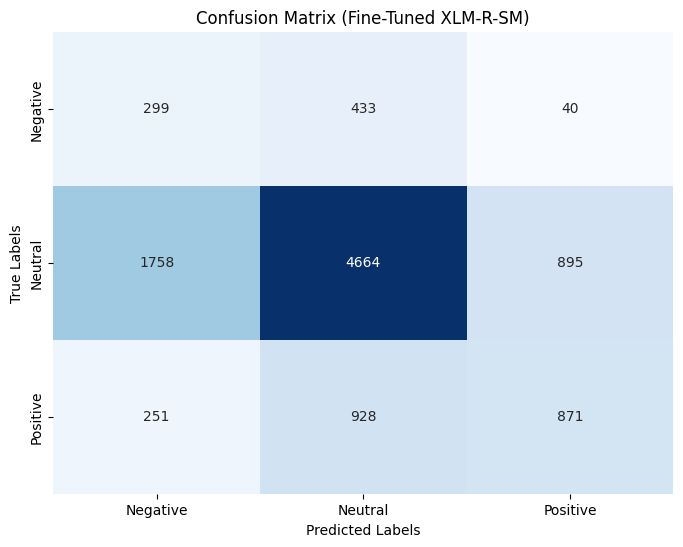

In [ ]:
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 加载微调后的模型和分词器
model_path = "./fine_tuned_model"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)

# 定义情感预测函数
def predict_sentiments(texts):
    inputs = tokenizer(texts, truncation=True, padding=True, return_tensors="pt", max_length=128)
    with torch.no_grad():
        outputs = model(**inputs)
    predictions = torch.argmax(outputs.logits, axis=-1)
    return predictions.numpy()

# 加载三个数据集及其真实标签
positive_tweets = pd.read_csv("/content/positive_sentiment_output.csv", header=None, names=["text"], sep="\t")
neutral_tweets = pd.read_csv("/content/neutral_sentiment_output.csv", header=None, names=["text"], sep="\t")
negative_tweets = pd.read_csv("/content/negative_sentiment_output.csv", header=None, names=["text"], sep="\t")

# 添加真实标签
positive_tweets["label"] = 2  # Positive
neutral_tweets["label"] = 1   # Neutral
negative_tweets["label"] = 0  # Negative

# 合并所有数据集
all_data = pd.concat([positive_tweets, neutral_tweets, negative_tweets], ignore_index=True)

# 预测标签
all_data["predicted_label"] = predict_sentiments(all_data["text"].tolist())

# 提取真实标签和预测标签
all_labels = all_data["label"].tolist()
all_predictions = all_data["predicted_label"].tolist()

# 计算评估指标
accuracy = accuracy_score(all_labels, all_predictions)
classification_rep = classification_report(all_labels, all_predictions, target_names=["Negative", "Neutral", "Positive"])
conf_matrix = confusion_matrix(all_labels, all_predictions)

# 输出结果
print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_rep)
print("\nConfusion Matrix:")
print(conf_matrix)

# 绘制混淆矩阵的热力图
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Negative", "Neutral", "Positive"],
            yticklabels=["Negative", "Neutral", "Positive"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix (Fine-Tuned XLM-R-SM)")
plt.show()


# **Without Fine-tune**

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

Accuracy: 0.6103

Classification Report:
              precision    recall  f1-score   support

    Negative       0.17      0.52      0.25       772
     Neutral       0.76      0.74      0.75      7317
    Positive       0.58      0.17      0.27      2050

    accuracy                           0.61     10139
   macro avg       0.50      0.48      0.42     10139
weighted avg       0.68      0.61      0.62     10139


Confusion Matrix:
[[ 403  357   12]
 [1642 5428  247]
 [ 352 1341  357]]


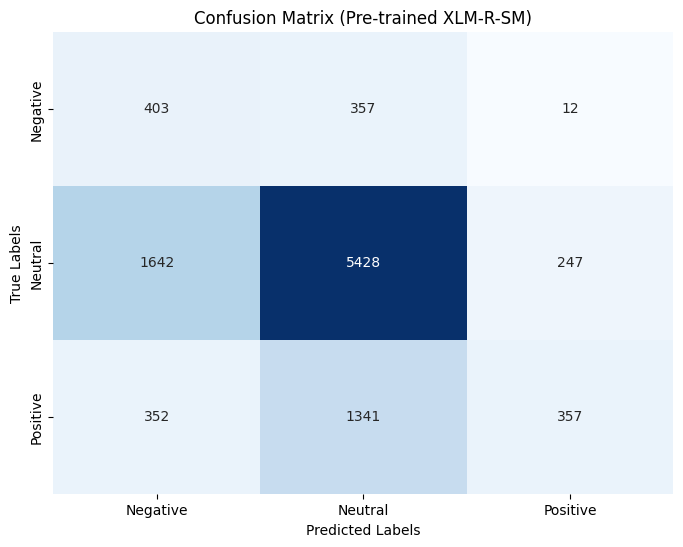

In [ ]:
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# **1. 加载数据集**
# 加载三个数据集及其真实标签
positive_tweets = pd.read_csv("/content/positive_sentiment_output.csv", header=None, names=["text"], sep="\t")
neutral_tweets = pd.read_csv("/content/neutral_sentiment_output.csv", header=None, names=["text"], sep="\t")
negative_tweets = pd.read_csv("/content/negative_sentiment_output.csv", header=None, names=["text"], sep="\t")

# 添加真实标签
negative_tweets["label"] = 0  # Negative
neutral_tweets["label"] = 1   # Neutral
positive_tweets["label"] = 2  # Positive

# 合并所有数据集
all_data = pd.concat([negative_tweets, neutral_tweets, positive_tweets], ignore_index=True)

# **2. 加载预训练的模型和分词器**
model_name = "cardiffnlp/twitter-xlm-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# **3. 定义预测函数**
def predict_sentiments(texts):
    inputs = tokenizer(texts, truncation=True, padding=True, return_tensors="pt", max_length=128)
    with torch.no_grad():
        outputs = model(**inputs)
    predictions = torch.argmax(outputs.logits, axis=-1)
    return predictions.numpy()

# **4. 预测标签**
all_data["predicted_label"] = predict_sentiments(all_data["text"].tolist())

# **5. 计算评估指标**
all_labels = all_data["label"].tolist()
all_predictions = all_data["predicted_label"].tolist()

accuracy = accuracy_score(all_labels, all_predictions)
classification_rep = classification_report(all_labels, all_predictions, target_names=["Negative", "Neutral", "Positive"])
conf_matrix = confusion_matrix(all_labels, all_predictions)

# **6. 输出结果**
print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_rep)
print("\nConfusion Matrix:")
print(conf_matrix)

# **7. 绘制混淆矩阵**
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Negative", "Neutral", "Positive"],
            yticklabels=["Negative", "Neutral", "Positive"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix (Pre-trained XLM-R-SM)")
plt.show()


In [ ]:
import pandas as pd

# Load datasets
negative_df = pd.read_csv('/content/negative_sentiment_output.csv')
neutral_df = pd.read_csv('/content/neutral_sentiment_output.csv')
positive_df = pd.read_csv('/content/positive_sentiment_output.csv')

# Randomly select 333 samples from each dataset
negative_sample = negative_df.sample(n=333, random_state=42)
neutral_sample = neutral_df.sample(n=333, random_state=42)
positive_sample = positive_df.sample(n=333, random_state=42)

# Add labels for classification
negative_sample['label'] = 0  # Negative
neutral_sample['label'] = 1   # Neutral
positive_sample['label'] = 2  # Positive

# Combine all samples into one dataset
final_dataset = pd.concat([negative_sample, neutral_sample, positive_sample], ignore_index=True)

# Shuffle the combined dataset
final_dataset = final_dataset.sample(frac=1, random_state=42).reset_index(drop=True)



Accuracy: 0.6737

Classification Report:
              precision    recall  f1-score   support

    Negative       0.22      0.92      0.35       772
     Neutral       0.98      0.60      0.74      7317
    Positive       0.73      0.86      0.79      2050

    accuracy                           0.67     10139
   macro avg       0.64      0.79      0.63     10139
weighted avg       0.87      0.67      0.72     10139


Confusion Matrix:
[[ 713   20   39]
 [2357 4363  597]
 [ 211   84 1755]]


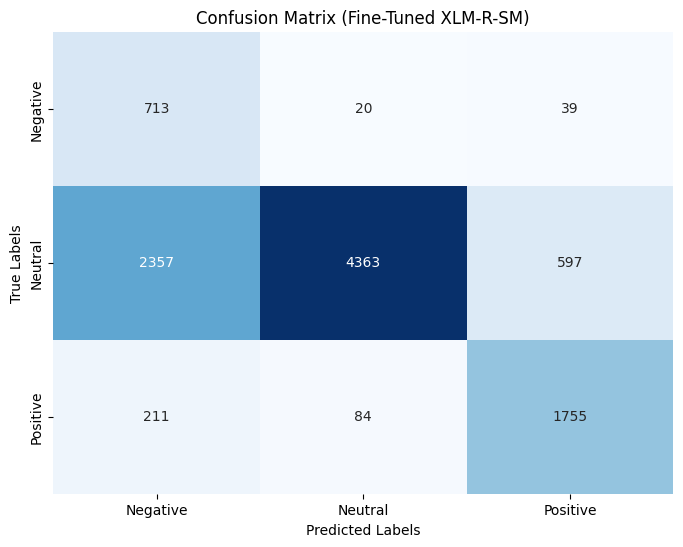

In [ ]:
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 加载微调后的模型和分词器
model_path = "./fine_tuned_model"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)

# 定义情感预测函数
def predict_sentiments(texts):
    inputs = tokenizer(texts, truncation=True, padding=True, return_tensors="pt", max_length=128)
    with torch.no_grad():
        outputs = model(**inputs)
    predictions = torch.argmax(outputs.logits, axis=-1)
    return predictions.numpy()

# 加载三个数据集及其真实标签
positive_tweets = pd.read_csv("/content/positive_sentiment_output.csv", header=None, names=["text"], sep="\t")
neutral_tweets = pd.read_csv("/content/neutral_sentiment_output.csv", header=None, names=["text"], sep="\t")
negative_tweets = pd.read_csv("/content/negative_sentiment_output.csv", header=None, names=["text"], sep="\t")

# 添加真实标签
positive_tweets["label"] = 2  # Positive
neutral_tweets["label"] = 1   # Neutral
negative_tweets["label"] = 0  # Negative

# 合并所有数据集
all_data = pd.concat([positive_tweets, neutral_tweets, negative_tweets], ignore_index=True)

# 预测标签
all_data["predicted_label"] = predict_sentiments(all_data["text"].tolist())

# 提取真实标签和预测标签
all_labels = all_data["label"].tolist()
all_predictions = all_data["predicted_label"].tolist()

# 计算评估指标
accuracy = accuracy_score(all_labels, all_predictions)
classification_rep = classification_report(all_labels, all_predictions, target_names=["Negative", "Neutral", "Positive"])
conf_matrix = confusion_matrix(all_labels, all_predictions)

# 输出结果
print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_rep)
print("\nConfusion Matrix:")
print(conf_matrix)

# 绘制混淆矩阵的热力图
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Negative", "Neutral", "Positive"],
            yticklabels=["Negative", "Neutral", "Positive"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix (Fine-Tuned XLM-R-SM)")
plt.show()
